**Importing Required Libraries**

In [611]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import config
import mysql.connector
from mysql.connector import errorcode

import requests
import pydotplus
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import plot_tree
from xgboost.sklearn import XGBClassifier

from scipy.sparse import csr_matrix
from imblearn.over_sampling import SMOTE

from time import time
import xgboost as xgb
from sklearn.svm import SVC  
from sklearn import tree, metrics, svm, datasets
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, average_precision_score, precision_score, f1_score
from sklearn.decomposition import PCA

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Collecting Relevant Data

## Webscraping

In [21]:
driver = webdriver.Chrome()
driver.get('https://www.whatbird.com/browse/attributes.aspx')
location_table = driver.find_element_by_class_name('BrowseTable')
links = location_table.find_elements_by_css_selector("a")

bird_families = [] 
bird_chars = []
for i in tqdm(range(1, len(links))):
    locale = driver.find_element_by_class_name('BrowseTable').find_elements_by_css_selector("a")[i]
    locale.click()
    landing_page = driver.current_url
    for ind in tqdm(range(len(driver.find_elements_by_xpath("//*[contains(@class,'ObjectLink')]")))):
        location_page = driver.current_url
        driver.find_elements_by_xpath("//*[contains(@class,'ObjectLink')]")[ind].click()
        driver.find_element_by_link_text('Identification').click()
        bird_chars_table = driver.find_element_by_class_name('contentbg')
        char_list = bird_chars_table.find_elements_by_css_selector('li')
        bird_text = [driver.find_element_by_id('BirdName').text]
        for i in char_list:
            bird_text.append(i.text)

        bird_chars.append(bird_text)
        bird_families.append(driver.find_element_by_id("Family").text)
        driver.get(location_page)

    driver.get('https://www.whatbird.com/browse/attributes.aspx')

## Combining Scraped Data and Removing Duplicates

In [356]:
birds = []
for elem in bird_chars:
    if elem not in birds:
        birds.append(elem)

## Connecting to MySQL/Creating a Database

In [540]:
db_name = 'Bird_Classifier_Project'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.pw

)
cur = cnx.cursor()

In [36]:
def create_database(cursor, database):
    try:
        cur.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cur.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cur, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)        

In [37]:
cur.execute("""
CREATE TABLE birds (
Family VARCHAR(255),
Name VARCHAR(255),
Bill_Shape VARCHAR(255),
Eye_Color VARCHAR(255),
Head_Pattern VARCHAR(255),
Crown_Color VARCHAR(255),
Forehead_Color VARCHAR(255),
Nape_Color VARCHAR(255),
Throat_Color VARCHAR(255),
Cere_Color VARCHAR(255),
Length_Range VARCHAR(255),
Weight VARCHAR(255),
Size VARCHAR(255),
Primary_Color VARCHAR(255),
Underparts VARCHAR(255),
Upperparts VARCHAR(255),
Back_Pattern VARCHAR(255),
Belly_Pattern VARCHAR(255),
Breast_Pattern VARCHAR(255),
Flight_Pattern VARCHAR(255),
Wingspan VARCHAR(255),
Wing_Shape VARCHAR(255),
Tail_Shape VARCHAR(255),
Tail_Pattern VARCHAR(255),
Upper_Tail VARCHAR(255),
Under_Tail VARCHAR(255),
Leg_Color VARCHAR(255)
)
""")

In [228]:
cleaner_list = []
for i in range(len(bird_chars)):
    cleaner_list.append(tuple((bird_chars[1][0][0],bird_chars[i][1:])))

In [486]:
nested_lists = []
for i in range(len(cleaner_list)):
    nested_lists.append([clieaner_list[i][0]]+cleaner_list[i][1])

In [487]:
unique_birds = list(nested_lists for nested_lists,_ in itertools.groupby(nested_lists))

In [497]:
for i in unique_birds:
    del i[0]

In [505]:
df = pd.DataFrame(unique_birds)
df['Family'] = bird_families

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Family
0,Mississippi Kite,Bill Shape: Hooked,Eye Color: Juvenile altering gradually to oran...,"Head pattern: Plain, Unique pattern",Crown Color: Gray,Forehead Color: Gray,Nape Color: Gray,Throat Color: Gray,Cere color: Gray,Length Range: 33-43 cm (13-17 in),...,Breast Pattern: Solid,Flight Pattern: Buoyant flight with steady win...,Wingspan Range: 86-94 cm (34-37 in),Wing Shape: Pointed-Wings,Tail shape: Notched Tail,Tail Pattern: Solid Black.,Upper Tail: Black,Under Tail: Black,Leg Color: Orange-yellow,"Family\nKites, Eagles and Hawks (Accipitridae)"
1,Swainson's Hawk,Bill Shape: Hooked,Eye Color: Gray or blue gray in Juvenal plumag...,"Head pattern: Plain, Unique pattern",Crown Color: Brown,Forehead Color: Brown,Nape Color: Brown,Throat Color: Red-brown with brown streaking.,Cere color: Yellow,Length Range: 48-51 cm (19-20 in),...,Breast Pattern: Solid,"Flight Pattern: Soars on thermals., Alternates...",Wingspan Range: 117-147 cm (46-58 in),Wing Shape: Pointed-Wings,Tail shape: Squared Tail,Tail Pattern: Narrow gray bands with wide dark...,Upper Tail: Gray with narrow bands.,Under Tail: Gray with narrow bands.,Leg Color: Yellow,"Family\nKites, Eagles and Hawks (Accipitridae)"
2,Reddish Egret,Bill Shape: Dagger,Eye Color: White to pale straw.,"Head pattern: Plain, Crested or plumed, Unique...",Crown Color: Red-brown,Forehead Color: Red-brown,Nape Color: Red-brown,Throat Color: Red-brown,Cere color: No Data,Length Range: 69-81 cm (27-32 in),...,Breast Pattern: Solid,Flight Pattern: Direct flight with buoyant ste...,Wingspan Range: 117 cm (46 in),"Wing Shape: Broad-Wings, Long-Wings",Tail shape: Squared Tail,Tail Pattern: Solid,Upper Tail: Gray,Under Tail: Gray,Leg Color: Blue-gray,"Family\nBitterns, Herons and Egrets (Ardeidae)"
3,Wood Stork,"Bill Shape: Dagger, Curved (up or down)","Eye Color: Dark brown in adults, pale blue in ...","Head pattern: Capped, Plain, Unique pattern",Crown Color: Bare gray skin.,Forehead Color: Bare gray skin.,Nape Color: Bare gray skin.,Throat Color: Bare gray skin.,Cere color: No Data,Length Range: 89-114 cm (35-45 in),...,Breast Pattern: Solid,Flight Pattern: Alternates between strong flap...,Wingspan Range: 165 cm (65 in),"Wing Shape: Broad-Wings, Pointed-Wings",Tail shape: Squared Tail,Tail Pattern: Solid,Upper Tail: Black,Under Tail: White,Leg Color: Gray-black,Family\nStorks (Ciconiidae)
4,Sandhill Crane,Bill Shape: Dagger,"Eye Color: Dark yellow-brown in hatchlings, be...","Head pattern: Capped, Unique pattern",Crown Color: Red and gray.,Forehead Color: Red,Nape Color: Gray,Throat Color: White,Cere color: No Data,Length Range: 86-122 cm (34-48 in),...,Breast Pattern: Solid,"Flight Pattern: Heavy, labored, steady wing be...",Wingspan Range: 185-229 cm (73-90 in),"Wing Shape: Pointed-Wings, Long-Wings",Tail shape: Squared Tail,Tail Pattern: Solid,Upper Tail: Gray,Under Tail: Gray,Leg Color: Black,Family\nCranes (Gruidae)


In [1223]:
df.to_csv('bird_dataset.csv')

In [519]:
df.drop_duplicates(subset ="0", 
                     keep = 'first', inplace = True) 

In [524]:
df.columns = df.columns.astype(str)
subset = df[['Family','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19', '20', '21', '22', '23', '24', '25']]
tuples = [tuple(x) for x in subset.values]

In [6]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.pw,
    database = db_name
)
cur = cnx.cursor()

In [531]:
for i in tqdm(tuples):
    try:
        stmt = """INSERT INTO birds (Family, Name, Bill_Shape, Eye_Color, Head_Pattern, Crown_Color, Forehead_Color,
        Nape_Color, Throat_Color, Cere_Color, Length_Range, Weight, Size, Primary_Color, Underparts, Upperparts, 
        Back_Pattern, Belly_Pattern, Breast_Pattern, Flight_Pattern, Wingspan, Wing_Shape, Tail_Shape, Tail_Pattern,
        Upper_Tail, Under_Tail, Leg_Color) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
        
        """
        cur.execute(stmt, (i))
        cnx.commit()
    except mysql.connector.Error as err:
        print(err, i)

In [7]:
cur.execute("""SELECT * FROM birds""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]

## Cleaning Up Columns

In [8]:
fams = list(df1.Family)

new_fams = []
for i in fams:
    new_fams.append(i.split("("))

real_fams = []
for i in new_fams:
    real_fams.append(i[1].split(")")[0])

df1['Family'] = real_fams

In [9]:
df1.Eye_Color = df1.Eye_Color.str[11:]

In [10]:
df1 = df1[~df1.Bill_Shape.str.contains("Eye Color")]
df1 = df1[~df1.Eye_Color.str.contains("Eye Color")]

In [11]:
### Removing redundant column label in each row ###

df1.Bill_Shape = df1.Bill_Shape.str[12:]
df1.Eye_Color = df1.Eye_Color.str[11:]
df1.Head_Pattern = df1.Head_Pattern.str[14:]
df1.Crown_Color = df1.Crown_Color.str[13:]
df1.Forehead_Color = df1.Forehead_Color.str[16:]
df1.Nape_Color = df1.Nape_Color.str[12:]
df1.Throat_Color = df1.Throat_Color.str[14:]
df1.Cere_Color = df1.Cere_Color.str[12:]
df1.Length_Range = df1.Length_Range.str[14:]
df1.Weight = df1.Weight.str[8:]
df1.Size = df1.Size.str[5:]
df1.Primary_Color = df1.Primary_Color.str[15:]
df1.Underparts = df1.Underparts.str[12:]
df1.Upperparts = df1.Upperparts.str[12:]
df1.Back_Pattern = df1.Back_Pattern.str[14:]
df1.Belly_Pattern = df1.Belly_Pattern.str[15:]
df1.Breast_Pattern = df1.Breast_Pattern.str[16:]
df1.Flight_Pattern = df1.Flight_Pattern.str[16:]
df1.Wingspan = df1.Wingspan.str[10:]
df1.Wing_Shape = df1.Wing_Shape.str[11:]
df1.Tail_Shape = df1.Tail_Shape.str[12:]
df1.Tail_Pattern = df1.Tail_Pattern.str[14:]
df1.Upper_Tail = df1.Upper_Tail.str[12:]
df1.Under_Tail = df1.Under_Tail.str[12:]
df1.Leg_Color = df1.Leg_Color.str[11:]

In [12]:
df1 = df1.drop(columns=['Eye_Color'])

# Training a Vanilla Classifier (Decision Tree)

In [395]:
X = pd.get_dummies(df1.drop(columns=['Family','Name','Size','Length_Range','Weight','Wingspan']))
y = (df1['Family'])

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=10)

In [257]:
dtclass = DecisionTreeClassifier(criterion='entropy',random_state=10)
dtclass.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [258]:
y_preds = dtclass.predict(X_test)


In [259]:
# Calculate Accuracy 
acc = accuracy_score(y_test,y_preds)*100
print("Accuracy score is {:.4}%".format(acc))

Accuracy score is 59.18%


**Initial Testing Score of 59.18%. Nice!**

In [263]:
def performance(y_true, y_predict):
    """ 
    Calculates and returns the performance score between 
    true and predicted values based on the metric chosen.
    """    
    r2 = (metrics.r2_score(y_true,y_predict))
    mse = metrics.mean_squared_error(y_true,y_predict)
    return r2,mse
performance(y_test,y_preds)

# Bagged Tree

In [236]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5,random_state=10),n_estimators=20,random_state=10)
bagged_tree.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=5,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=10,
                                                        splitter='best'),
         

In [260]:
print(bagged_tree.score(X_train,y_train))
print(bagged_tree.score(X_test,y_test))

0.4263157894736842

# Random Forest

## Vanilla Model

In [239]:
forest = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=10)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [240]:
print(forest.score(X_train,y_train))
print(forest.score(X_test,y_test))

0.5245614035087719

In [242]:
dt_cv_score = cross_val_score(dtclass,X,y,cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)
print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score*100))

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Mean Cross Validation Score: 57.62%


## Gridsearching Random Forest

In [29]:
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16 ,18, 20, 22, 24, 26, 28, 30, 32, 34],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 3, 4, 5, 6]
}
dt_grid_search = GridSearchCV(dtclass,dt_param_grid,cv=3,return_train_score=True)

dt_grid_search.fit(X, y)

In [31]:
dt_gs_training_score = dt_grid_search.cv_results_['mean_train_score']
dt_gs_testing_score = dt_grid_search.score(X,y)

print("Mean Training Score: {:.4}%".format(np.mean(dt_gs_training_score) * 100))
print("Mean Testing Score: {:.4}%".format(np.mean(dt_gs_testing_score) * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 63.71%
Mean Testing Score: 80.61%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [265]:
forest_class = RandomForestClassifier()
dt_cv_score = cross_val_score(forest_class,X,y,cv=3)
mean_rf_cv_score = np.mean(dt_cv_score)
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWa

Mean Cross Validation Score for Random Forest Classifier: 58.11%


In [33]:
rf_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16 ,18, 20, 22, 24, 26, 28, 30, 32, 34],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 3, 4, 5, 6],
    "n_estimators" : [10, 30, 100]
}

In [34]:
start = time.time()
rf_grid_search = GridSearchCV(forest_class,rf_param_grid,cv=3)
rf_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Testing Accuracy: 66.38%
Total Runtime for Grid Search on Random Forest Classifier: 686.8 seconds

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


 **Up to 66.38%. Better!**

## Changed Target to Size and Combined 5 categories into 3

In [266]:
df1.loc[df1['Size'] == ' Very Small (3 - 5 in)', 'Size'] = ' Small (5 - 9 in)'
df1.loc[df1['Size'] == ' Very Large (32 - 72 in)'] = ' Large (16 - 32 in)'

In [644]:
df1.Size.value_counts()

 Small (5 - 9 in)      391
 Medium (9 - 16 in)    219
 Large (16 - 32 in)    205
Name: Size, dtype: int64

In [651]:
X = pd.get_dummies(df1.drop(columns=['Family','Name','Size','Length_Range','Weight','Wingspan']))
y = (df1['Size'])

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state=10)

In [652]:
forest = RandomForestClassifier(random_state=10)
forest.fit(X_train,y_train)

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [653]:
forest.score(X_test,y_test)

0.647239263803681

In [654]:
dt_cv_score = cross_val_score(forest,X,y,cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)
print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score*100))

Mean Cross Validation Score: 67.12%


In [248]:
forest_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16 ,18, 20, 22, 24, 26, 28, 30, 32, 34],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 3, 4, 5, 6]
}

dt_grid_search = GridSearchCV(forest,forest_param_grid,cv=3,return_train_score=True)

dt_grid_search.fit(X, y)

dt_gs_training_score = dt_grid_search.cv_results_['mean_train_score']
dt_gs_testing_score = dt_grid_search.score(X,y)

print("Mean Training Score: {:.4}%".format(np.mean(dt_gs_training_score) * 100))
print("Mean Testing Score: {:.4}%".format(np.mean(dt_gs_testing_score) * 100))
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

In [660]:
forest = RandomForestClassifier(random_state=10, max_depth=34, min_samples_leaf=1, min_samples_split=5, criterion='gini')
forest.fit(X_train,y_train)

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=34, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [661]:
dt_cv_score = cross_val_score(forest,X,y,cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)
print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score*100))

Mean Cross Validation Score: 69.21%


In [662]:
y_pred = forest.predict(X_test)

Confusion Matrix, without normalization
[[ 53  25  11]
 [ 22  22  41]
 [ 11  16 125]]
[0.61627907 0.34920635 0.70621469]


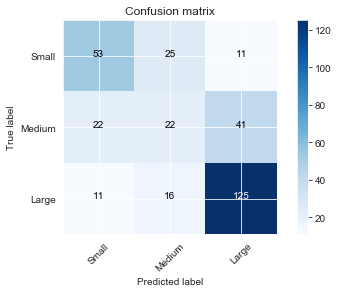

In [664]:
cm = confusion_matrix(y_test,y_pred)
classes = ['Small','Medium','Large']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
print(precision_score(y_test, y_pred,average=None))

## Support Vector Classifier

In [44]:
tic = time()
svclassifier = SVC(kernel='rbf', C=1)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
toc = time()
print("run time is {} seconds".format(toc-tic))

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


run time is 1.3344769477844238 seconds


In [666]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[ 53  25  11]
 [ 22  22  41]
 [ 11  16 125]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.62      0.60      0.61        89
 Medium (9 - 16 in)       0.35      0.26      0.30        85
   Small (5 - 9 in)       0.71      0.82      0.76       152

           accuracy                           0.61       326
          macro avg       0.56      0.56      0.55       326
       weighted avg       0.59      0.61      0.60       326

The accuracy score is 0.6134969325153374


In [667]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [669]:
svc_param_selection(X, y, 5)

{'C': 10, 'gamma': 0.01}

## Re-running SVC with Optimal Parameters

In [670]:

tic = time()
svclassifier = SVC(kernel='rbf', C=10, gamma=0.01)  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
toc = time()
print("run time is {} seconds".format(toc-tic))

run time is 1.660149097442627 seconds


In [671]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[ 55  30   4]
 [ 26  28  31]
 [ 14  21 117]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.58      0.62      0.60        89
 Medium (9 - 16 in)       0.35      0.33      0.34        85
   Small (5 - 9 in)       0.77      0.77      0.77       152

           accuracy                           0.61       326
          macro avg       0.57      0.57      0.57       326
       weighted avg       0.61      0.61      0.61       326

The accuracy score is 0.6134969325153374


## Using Synthetic Minority Over-sampling Technique (SMOTE) on Imbalanced Dataset

In [674]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [679]:
smote = SVC(kernel='rbf', C=10, gamma=0.01).fit(X_train,y_train)
smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)

0.6134969325153374

In [680]:
print(confusion_matrix(y_test, smote_pred))
print(classification_report(y_test,smote_pred))

[[ 55  30   4]
 [ 26  28  31]
 [ 14  21 117]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.58      0.62      0.60        89
 Medium (9 - 16 in)       0.35      0.33      0.34        85
   Small (5 - 9 in)       0.77      0.77      0.77       152

           accuracy                           0.61       326
          macro avg       0.57      0.57      0.57       326
       weighted avg       0.61      0.61      0.61       326



In [57]:
df1.to_csv('real_bird_dataset.csv')

## Gridsearched Neural Network Using Bag of Words

In [711]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df1.Flight_Pattern)

In [713]:
x_words = X.toarray()

In [714]:
x_words = pd.DataFrame(x_words)

In [715]:
x_words.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [716]:
bow_X = pd.concat([df1,x_words], axis=1, ignore_index=True)

In [717]:
bow_X = bow_X.drop(columns=[0,1,9,10,11,19])

In [718]:
bow_with_features = pd.get_dummies(bow_X)
y = df1['Size']

In [719]:
X_train,X_test, y_train,y_test = train_test_split(bow_with_features,y,test_size=0.3)

In [197]:
forest = RandomForestClassifier(random_state=45)
forest.fit(X_train,y_train)

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)

In [198]:
dt_cv_score = cross_val_score(forest,X,y,cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)
print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score*100))

Mean Cross Validation Score: 63.56%


In [199]:
rf_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16 ,18, 20, 22, 24, 26, 28, 30, 32, 34],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf" : [1, 2, 3, 4, 5, 6],
    "n_estimators" : [10, 30, 100]
}

In [71]:
dt_grid_search = GridSearchCV(forest,rf_param_grid,cv=3,return_train_score=True)

dt_grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=45,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'crit

In [213]:
print("Testing Accuracy: {:.4}%".format(dt_grid_search.best_score_ * 100))
print("")
print("Optimal Parameters: {}".format(dt_grid_search.best_params_))

Testing Accuracy: 67.61%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}


In [720]:
### SMOTE ###
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Random-searched SVC Using Bag of Words

In [721]:
svc_param_selection(bow_with_features, y, 5)

KeyboardInterrupt: 

In [722]:
smote = SVC(kernel='rbf', C=10, gamma=0.01,random_state=10).fit(X_train,y_train)
smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)

0.7306122448979592

In [723]:
print(confusion_matrix(y_test, smote_pred))
print(classification_report(y_test,smote_pred))
print("The accuracy score is" + " "+ str(accuracy_score(y_test, smote_pred)))

[[51 12  2]
 [13 32 26]
 [ 1 12 96]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.78      0.78      0.78        65
 Medium (9 - 16 in)       0.57      0.45      0.50        71
   Small (5 - 9 in)       0.77      0.88      0.82       109

           accuracy                           0.73       245
          macro avg       0.71      0.71      0.70       245
       weighted avg       0.72      0.73      0.72       245

The accuracy score is 0.7306122448979592


In [734]:
def svc_randomizedsearchCV(X, y, nfolds):
    degrees = [2,3,4,5]
    kernels = ['rbf','poly']
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels, 'degree': degrees}
    grid_search = RandomizedSearchCV(svm.SVC(), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [735]:
svc_randomizedsearchCV(bow_with_features,y,5)

{'kernel': 'poly', 'gamma': 1, 'degree': 2, 'C': 0.01}

In [754]:
smote = SVC(kernel='rbf', C=1, gamma=0.01, degree=5,random_state=10).fit(X_train,y_train)
smote_pred = smote.predict(X_test)

In [755]:
precision_score(y_test, smote_pred,average=None)

array([0.79365079, 0.58490566, 0.76744186])

In [756]:
print(confusion_matrix(y_test, smote_pred))
print(classification_report(y_test,smote_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, smote_pred)))

[[50 13  2]
 [12 31 28]
 [ 1  9 99]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.79      0.77      0.78        65
 Medium (9 - 16 in)       0.58      0.44      0.50        71
   Small (5 - 9 in)       0.77      0.91      0.83       109

           accuracy                           0.73       245
          macro avg       0.72      0.70      0.70       245
       weighted avg       0.72      0.73      0.72       245

The accuracy score is 0.7346938775510204


**BEST MODEL  ^^^^^**

# Attempting Better Score Using Principle Component Analysis


In [538]:
X = bow_with_features
y = (df1['Size'])

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=10)

In [478]:
pca = PCA()
transformed = pca.fit_transform(X)

# Your code here 

first_two_comp = (transformed[:,0], transformed[:,1]);

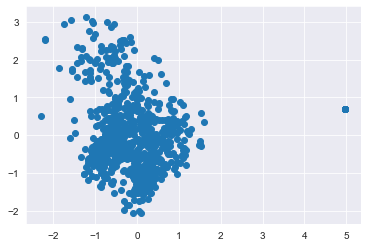

In [479]:
plt.scatter(transformed[:,0], transformed[:,1]);

In [480]:
cov = np.cov(transformed)

array([[ 0.03615488,  0.00626905,  0.00374305, ...,  0.00059026,
         0.0004335 , -0.00312162],
       [ 0.00626905,  0.03780391, -0.00034924, ...,  0.00018773,
         0.00125791, -0.00229525],
       [ 0.00374305, -0.00034924,  0.02292258, ..., -0.00233838,
        -0.00372542, -0.0023643 ],
       ...,
       [ 0.00059026,  0.00018773, -0.00233838, ...,  0.02645058,
        -0.00196197, -0.00183126],
       [ 0.0004335 ,  0.00125791, -0.00372542, ..., -0.00196197,
         0.0421065 ,  0.00292587],
       [-0.00312162, -0.00229525, -0.0023643 , ..., -0.00183126,
         0.00292587,  0.02516942]])

In [481]:
eigen_value, eigen_vector = np.linalg.eig(cov)

In [482]:
e_indices = np.argsort(eigen_value)[::-1] #Get the index values of the sorted eigenvalues
eigenvectors_sorted = eigen_vector[:,e_indices]

In [483]:
transformed = eigenvectors_sorted.dot(transformed).T

array([[-1.56844305+0.02003691j, -0.33711334+0.02003691j,
        -1.43072285+0.02003691j, ..., -0.41433232+0.02003691j,
        -0.67127222+0.02003691j, -0.23285208+0.02003691j],
       [-0.07362514+0.06052449j,  0.19106085+0.06052449j,
         0.42629408+0.06052449j, ..., -0.23879843+0.06052449j,
        -0.40159658+0.06052449j,  1.58573903+0.06052449j],
       [-0.0571983 +0.03842199j, -0.51588532+0.03842199j,
         0.74838199+0.03842199j, ...,  1.0791471 +0.03842199j,
         0.98407192+0.03842199j, -1.0287157 +0.03842199j],
       [-0.62367361-0.05828554j, -0.68640537-0.05828554j,
        -0.12398604-0.05828554j, ..., -0.19945926-0.05828554j,
         0.34282461-0.05828554j,  0.18161854-0.05828554j],
       [ 0.10998571-0.0014008j , -1.73048876-0.0014008j ,
         0.58541881-0.0014008j , ..., -0.33847096-0.0014008j ,
        -0.2963644 -0.0014008j ,  0.69045215-0.0014008j ]])

In [484]:
pcs=pd.DataFrame(first_two_comp).T

In [487]:
print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [6.22500654e-02 4.05656124e-02 3.85501061e-02 2.75046607e-02
 2.46004373e-02 2.31763528e-02 2.04719491e-02 1.62398418e-02
 1.46289104e-02 1.37767455e-02 1.33382109e-02 1.26105281e-02
 1.11430197e-02 1.04688475e-02 1.02853021e-02 9.41727278e-03
 9.01665687e-03 8.92724218e-03 8.57330188e-03 8.44268638e-03
 8.19616165e-03 7.96998555e-03 7.73051627e-03 7.15020368e-03
 7.04927261e-03 6.90533854e-03 6.74844042e-03 6.48260771e-03
 6.16416457e-03 5.98079310e-03 5.90596549e-03 5.75391919e-03
 5.50733658e-03 5.46669397e-03 5.09500430e-03 5.00699691e-03
 4.94890655e-03 4.76758029e-03 4.67269978e-03 4.56666751e-03
 4.49002026e-03 4.36540647e-03 4.23451451e-03 4.19575209e-03
 4.13665806e-03 4.03237501e-03 3.93978520e-03 3.86877960e-03
 3.81437987e-03 3.78531810e-03 3.77556783e-03 3.69188130e-03
 3.65916942e-03 3.57328041e-03 3.45051412e-03 3.43117215e-03
 3.36255106e-03 3.34444004e-03 3.22142829e-03 3.17704003e-03
 3.13073592e-03 3.07523678e-03 3.04350201e-03 3.03649456e

In [279]:
X = pcs
y = (df1['Size'])
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model = SVC(kernel='rbf', C=10, gamma=0.001, degree=4).fit(X_train,y_train)
model.fit(X_train, Y_train)
Yhat = model.predict(X_test)
acc = metrics.accuracy_score(Yhat, Y_test)
end = time.time()
print("Accuracy:",acc)
print ("Time Taken:", end - start)

Accuracy: 0.5460122699386503
Time Taken: 0.03277993202209473


**After playing around with the different eigenvalues, accuracy using PCA isn't as good as our SVC model**

# Some Classification Evaluation! // BEST MODEL: SMOTE SVC

Target Variable
Size
 Large (16 - 32 in)    205
 Medium (9 - 16 in)    219
 Small (5 - 9 in)      391
Name: Size, dtype: int64


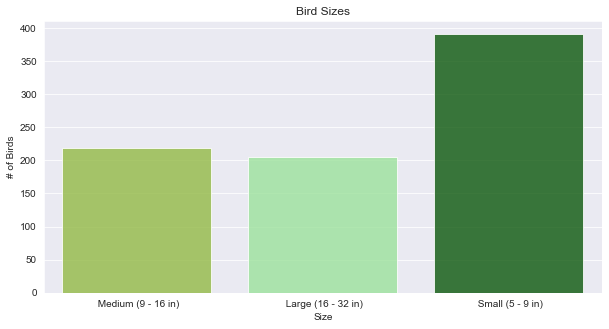

In [314]:
# Survival Count
print('Target Variable')
print(df1.groupby(['Size']).Size.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df1['Size'], alpha =.80, palette= ['yellowgreen','lightgreen','darkgreen'])
plt.title('Bird Sizes')
plt.ylabel('# of Birds')
plt.show()

In [370]:
cm = confusion_matrix(y_test,smote_pred)
classes = ['Small','Medium','Large']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[ 46  11   1]
 [ 14  34  18]
 [  5  15 101]]
[0.34722222 0.35185185 0.45378151]


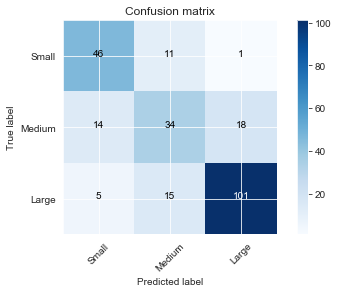

In [641]:
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
print(precision_score(y_test, smote_pred,average=None))

In [377]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', smote_pred[0:25])

True: [' Small (5 - 9 in)' ' Small (5 - 9 in)' ' Medium (9 - 16 in)'
 ' Large (16 - 32 in)' ' Small (5 - 9 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Medium (9 - 16 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Small (5 - 9 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Medium (9 - 16 in)' ' Small (5 - 9 in)' ' Small (5 - 9 in)'
 ' Large (16 - 32 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)']
Pred: [' Small (5 - 9 in)' ' Small (5 - 9 in)' ' Medium (9 - 16 in)'
 ' Medium (9 - 16 in)' ' Small (5 - 9 in)' ' Small (5 - 9 in)'
 ' Medium (9 - 16 in)' ' Small (5 - 9 in)' ' Small (5 - 9 in)'
 ' Small (5 - 9 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Small (5 - 9 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Large (16 - 32 in)' ' Medium (9 - 16 in)'
 ' Small (5 - 9 in)' ' Small (5 - 9 in)' ' Small (5 - 9 in)'
 ' La

In [382]:
print(metrics.precision_score(y_test, smote_pred, average=None))
print(metrics.recall_score(y_test, smote_pred, average=None))

[0.70769231 0.56666667 0.84166667]


In [390]:
#calculating the F1 score
2*(metrics.precision_score(y_test, smote_pred,average=None)*metrics.recall_score(y_test, smote_pred,average=None))/(metrics.precision_score(y_test, smote_pred,average=None)+metrics.recall_score(y_test, smote_pred,average=None))
   

array([0.74796748, 0.53968254, 0.83817427])

In [761]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
THRESHOLD = 0.5
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[np.mean(metrics.recall_score(y_test, smote_pred,average=None)),
                   np.mean(metrics.precision_score(y_test, smote_pred,average=None)), np.mean(metrics.f1_score(y_test, smote_pred,average=None))], 
             index=["recall", "precision", "F1"])

/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,0
recall,0.704702
precision,0.715333
F1,0.704394


Text(0, 0.5, 'Frequency')

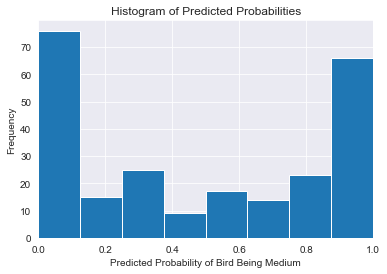

In [795]:
y_pred_prob = logreg.predict_proba(X_test)[:, 2]
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Bird Being Medium')
plt.ylabel('Frequency')

## AdaBoost

In [453]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, X, y, cv=3))
print("Mean Cross Validation Score for AdaBoost: {:.4}%".format(adaboost_mean_cv_score * 100))

Mean Cross Validation Score for AdaBoost: 65.03%


In [455]:
adaboost_param_grid = {
    'n_estimators': [50,100,250, 500],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [456]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X, y)
print("Testing Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on AdaBoost: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Testing Accuracy: 66.38%
Total Runtime for Grid Search on AdaBoost: 1.033e+04 seconds

Optimal Parameters: {'learning_rate': 1.0, 'n_estimators': 250}


In [462]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [464]:
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

In [468]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average='weighted')
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    

display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

Model: Gradient Boosted Trees
Accuracy: 0.9912280701754386
F1-Score: 0.9912100456895858

Model: Gradient Boosted Trees
Accuracy: 0.7510204081632653
F1-Score: 0.7454922179043959


In [470]:
gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
print(gbt_confusion_matrix)
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)



[[ 45  13   6]
 [ 10  28  19]
 [  3  10 111]]
                     precision    recall  f1-score   support

 Large (16 - 32 in)       0.78      0.70      0.74        64
 Medium (9 - 16 in)       0.55      0.49      0.52        57
   Small (5 - 9 in)       0.82      0.90      0.85       124

           accuracy                           0.75       245
          macro avg       0.71      0.70      0.70       245
       weighted avg       0.74      0.75      0.75       245



In [471]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X, y, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.7423722066123184


## XG Boost

In [637]:
X = bow_with_features
y = (df1['Size'])
X.columns = X.columns.astype(str)
X.columns = X.columns.str.replace(' ', '_')
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=10)

In [420]:
xgb_param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [583]:
clfX=XGBClassifier()
clfX.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [500]:
grid_clf = GridSearchCV(clfX, xgb_param_grid, scoring='accuracy', cv=5, n_jobs=1)
grid_clf.fit(bow_with_features, y)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)
print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
print("Testing Accuracy(Best Score): {:.4}%".format(grid_clf.best_score_ * 100))


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 250
subsample: 0.7

Training Accuracy: 92.98%
Validation accuracy: 95.92%
Testing Accuracy(Best Score): 72.39%


In [617]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(13,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

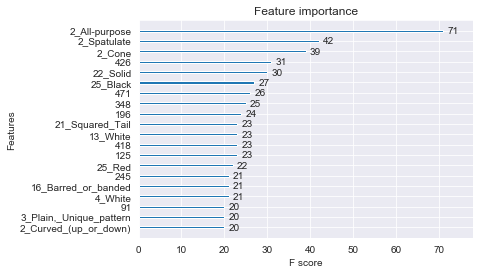

In [633]:
from xgboost import plot_importance
plot_importance(clfX,max_num_features=20);

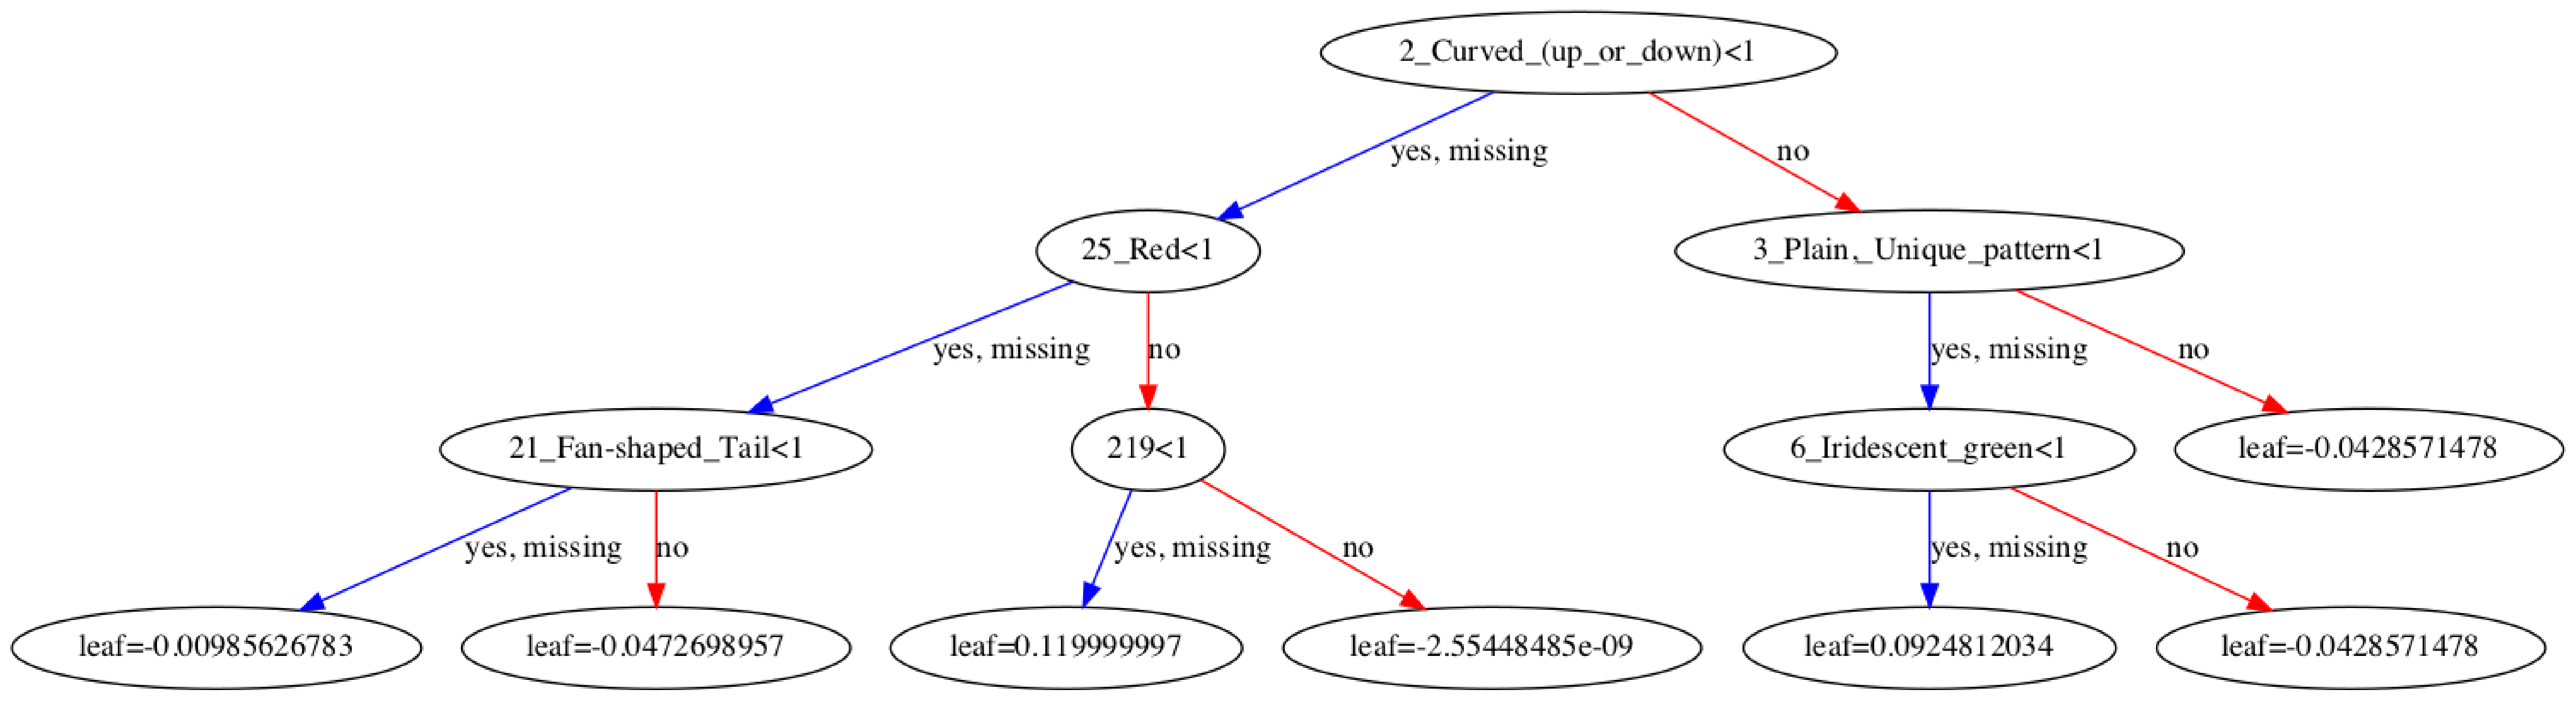

In [609]:
plot_tree(clfX, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(100, 60)